In [ ]:
pip install pygame

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense 

class PolicyGradientNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256,name='Reinforce', checkpoint_folder='agent/Reinforce'):
        super(PolicyGradientNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_folder = checkpoint_folder
        self.checkpoint_file = os.path.join(self.checkpoint_folder, name+'_ac')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.pi = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)
        pi = self.pi(value)

        return pi

class Rewarder(keras.Model):
    def __init__(self,num_hidden_units= 256):
        super().__init__()
        self.shared_1 = Dense(num_hidden_units,activation='relu')
        self.reward  = Dense(1)

    def call(self,input_obs):
        x = self.shared_1(input_obs)
        return self.reward(x)

In [9]:
import tensorflow as tf
# from network import PolicyGradientNetwork, Rewarder
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
import random
import numpy as np



class ReinforceAgent:
    def __init__(self, alpha=0.003, gamma=0.99, n_actions=5,layer1_size=256, layer2_size=256):
        self.gamma = gamma
        self.learning_rate = alpha
        self.n_actions = n_actions
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.policy = PolicyGradientNetwork(n_actions=n_actions)
        self.policy.compile(optimizer=Adam(learning_rate=self.learning_rate))
        self.rewarder = Rewarder(layer1_size)
        self.reward_loss = 0

    def take_action(self, observation):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        probs = self.policy(state)
        action_probs = tfp.distributions.Categorical(probs=probs)
        action = action_probs.sample() 
        return action.numpy()[0][0]

    def save_transition(self, observation, action, reward):
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)

    def train(self):
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        rewards = np.array(self.reward_memory)

        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            sum_of_G = 0
            discount = 1
            for k in range(t, len(rewards)):
                sum_of_G += rewards[k] * discount
                discount *= self.gamma
            G[t] = sum_of_G
        
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, self.state_memory)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.policy(state)
                action_probs = tfp.distributions.Categorical(probs=probs)
                log_prob = action_probs.log_prob(actions[idx])
                loss += -g * tf.squeeze(log_prob)

        gradient = tape.gradient(loss, self.policy.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(gradient, self.policy.trainable_variables))
        
        
        print("select preference:\n 1:first\n 2:second\n 0:same")
        reward1 = []
        reward2 = []
        pref=input()
        if pref == "1" :
            dist=[1,0]
        if pref == "2" :
            dist=[0,1]
        if pref == "0" :
            dist=[1,1]
        with tf.GradientTape()as tape:
             # fitting the reward function 
            for j in range(len(self.state_memory) // 2):
              reward1.append(self.rewarder(self.state_memory[j]))
              # print("this is the reward1",reward1)
            for k in range(len(self.state_memory) // 2,len(self.state_memory)):
               reward2.append(self.rewarder(self.state_memory[j]))
              # print("this is the reward2",reward2)
            p1 = tf.exp(tf.math.reduce_sum(reward1))/tf.exp(tf.math.reduce_sum(reward1))+tf.exp(tf.math.reduce_sum(reward2))
            p2 = tf.exp(tf.math.reduce_sum(reward2))/tf.exp(tf.math.reduce_sum(reward1))+tf.exp(tf.math.reduce_sum(reward2))
            loss =- tf.math.log(p1)*dist[0]+tf.math.log(p2)*dist[1]
        grads = tape.gradient(loss,self.rewarder.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(grads,self.rewarder.trainable_variables))
        self.reward_loss = loss
        self.state_memory = []
        print(self.reward_memory)
        self.reward_memory = []
        self.action_memory = []

        return self.reward_loss

    def save_agent(self):
        print('... saving agent ...')
        self.policy.save_weights(self.policy.checkpoint_file)

    def load_agent(self):
        print('... loading agent ...')
        self.policy.load_weights(self.policy.checkpoint_file)



In [4]:
from random import randint, choice
from collections import deque
from time import sleep
import pygame, time
import numpy as np
import tensorflow as tf
# from agent import Rewarder
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"


class Field:
    def __init__(self, height=10, width=5):
        self.width      = width
        self.height     = height
        self.body       = np.zeros(shape=(self.height, self.width))
    
    def update_field(self,walls, player):
        try:
            # Clear the field:
            self.body = np.zeros(shape=(self.height, self.width))
            # Put the walls on the field:
            for wall in walls:
                if not wall.out_of_range :
                    self.body[wall.y:min(wall.y+wall.height,self.height),:] = wall.body

            # Put the player on the field:
            self.body[player.y:player.y+player.height,
                      player.x:player.x+player.width] += player.body 
        except :
            pass

######################################################################################################################################

class Wall:        
    def __init__(self, height = 5, width=100,  hole_width = 20,
                 y = 0, speed = 1, field = None):
        self.height       = height
        self.width        = width
        self.hole_width   = hole_width
        self.y            = y
        self.speed        = speed
        self.field        = field
        self.body_unit     = 1
        self.body         = np.ones(shape = (self.height, self.width))*self.body_unit
        self.out_of_range = False
        self.create_hole()
    def create_hole(self):
        hole = np.zeros(shape = (self.height, self.hole_width))
        hole_pos = randint(0,self.width-self.hole_width)
        self.body[ : , hole_pos:hole_pos+self.hole_width] = 0
    def move(self):
        self.y += self.speed
        self.out_of_range = True if ((self.y + self.height) > self.field.height) else False

######################################################################################################################################


class Player:
    def __init__(self, height = 5, max_width = 10 , width=2,
                 x = 0, y = 0, speed = 2):
        self.height        = height
        self.max_width     = max_width
        self.width         = width
        self.x             = x
        self.y             = y
        self.speed         = speed
        self.body_unit     = 2
        self.body          = np.ones(shape = (self.height, self.width))*self.body_unit
        self.stamina       = 20
        self.max_stamina   = 20
    def move(self, field, direction = 0 ):
        '''
        Moves the player :
         - No change          = 0
         - left, if direction  = 1
         - right, if direction = 2
        '''
        val2dir   = {0:0 , 1:-1 , 2:1}
        direction = val2dir[direction]
        next_x = (self.x + self.speed*direction)
        if not (next_x + self.width > field.width or next_x < 0):
            self.x += self.speed*direction
            self.stamina -= 1 
    def change_width(self, action = 0):
        '''
        Change the player's width:
         - No change          = 0
         - narrow by one unit = 3
         - widen by one unit  = 4
        '''
        val2act   = {0:0 , 3:-1 , 4:1}
        action = val2act[action]
        new_width = self.width+action
        player_end = self.x + new_width
        if new_width <= self.max_width and new_width > 0 and player_end <= self.max_width:
            self.width = new_width
            self.body  = np.ones(shape = (self.height, self.width))*self.body_unit

######################################################################################################################################



class Environment:
    P_HEIGHT      = 2  # Height of the player
    F_HEIGHT      = 20 # Height of the field
    W_HEIGHT      = 2  # Height of the walls
    WIDTH         = 10 # Width of the field and the walls
    MIN_H_WIDTH   = 2  # Minimum width of the holes
    MAX_H_WIDTH   = 6  # Maximum width of the holes
    MIN_P_WIDTH   = 2  # Minimum Width of the player
    MAX_P_WIDTH   = 6  # Maximum Width of the player
    HEIGHT_MUL    = 30 # Height Multiplier (used to draw np.array as blocks in pygame )
    WIDTH_MUL     = 40 # Width Multiplier (used to draw np.array as blocks in pygame )
    WINDOW_HEIGHT = (F_HEIGHT+1) * HEIGHT_MUL # Height of the pygame window
    WINDOW_WIDTH  = (WIDTH) * WIDTH_MUL       # Widh of the pygame window
    WALL_SPEED    = 1
    ENVIRONMENT_SHAPE = (F_HEIGHT,WIDTH,1)
    ACTION_SPACE      = [0,1,2,3,4]
    ACTION_SPACE_SIZE = len(ACTION_SPACE)
    PUNISHMENT        = -100  # Punishment increment
    REWARD            = 10    # Reward increment
    Rewarder = Rewarder(256) 
    score             = 0     # Initial Score
    # Rewarder = Rewarder(256)
    MOVE_WALL_EVERY   = 4     # Every how many frames the wall moves.
    MOVE_PLAYER_EVERY = 3     # Every how many frames the player moves.
    frames_counter    = 0

    def __init__(self):
        # Colors:
        self.BLACK      = (25,25,25)
        self.WHITE      = (255,255,255)
        self.RED        = (255, 80, 80)
        self.BLUE       = (80, 80, 255)
        self.field = self.walls = self.player = None
        self.current_state = self.reset()
        self.val2color  = {0:self.WHITE, self.walls[0].body_unit:self.BLACK,
                           self.player.body_unit:self.BLACK, self.MAX_VAL:self.RED}
    def reset(self):
        self.score          = 0
        self.frames_counter = 0
        self.game_over      = False
                                
        self.field = Field(height=self.F_HEIGHT, width=self.WIDTH )
        w1    = Wall( height = self.W_HEIGHT, width=self.WIDTH,
                      hole_width = randint(self.MIN_H_WIDTH,self.MAX_H_WIDTH),
                     field = self.field)
        self.walls = deque([w1])
        p_width = randint(self.MIN_P_WIDTH,self.MAX_P_WIDTH)
        self.player    = Player( height = self.P_HEIGHT, max_width = self.WIDTH,
                                width = p_width,
                                x = randint(0,self.field.width-p_width),
                                y = int(self.field.height*0.7), speed = 1)
        self.MAX_VAL = self.player.body_unit + w1.body_unit
        # Update the field :
        self.field.update_field(self.walls, self.player)
        
        observation = self.field.body/self.MAX_VAL
        return observation
    def print_text(self, WINDOW = None, text_cords = (0,0), center = False,
                   text = "", color = (0,0,0), size = 32):
        pygame.init()
        font = pygame.font.Font('freesansbold.ttf', size) 
        text_to_print = font.render(text, True, color) 
        textRect = text_to_print.get_rect()
        if center:
            textRect.center = text_cords
        else:
            textRect.x = text_cords[0]
            textRect.y = text_cords[1]
        WINDOW.blit(text_to_print, textRect)
        
    def step(self, action):
        global score_increased

        self.frames_counter += 1
        reward = 0

        # If the performed action is (move) then player.move method is called:
        if action in [1,2]:
            # print(action)
            self.player.move(direction = action, field = self.field)
        # If the performed action is (change_width) then player.change_width method is called:
        elif action in [3,4]:
            self.player.change_width(action = action)                
        
        # Move the wall one step (one step every WALL_SPEED frames):
        if self.frames_counter % self.WALL_SPEED == 0:
            # move the wall one step
            self.walls[-1].move()
            # reset the frames counter
            self.frames_counter = 0
        
        # Update the field :
        self.field.update_field(self.walls, self.player)
        self.current_state = self.field.body/self.MAX_VAL
        # print(tf.expand_dims(self.current_state, axis = 0)[0].shape)

        # If the player passed a wall successfully increase the reward +1
        if ((self.walls[-1].y) == (self.player.y + self.player.height)) and not score_increased :
            # reward += self.REWARD
            # reward = tf.math.reduce_sum(self.Rewarder(tf.expand_dims(self.current_state,0)))
            reward = self.Rewarder(tf.expand_dims(self.current_state,0))[0,0]

            # print("thgis is tge reward ", tf.math.reduce_sum(reward))
            # self.score  += self.REWARD
            
            # Increase player's stamina every time it passed a wall successfully  
            self.player.stamina = min(self.player.max_stamina, self.player.stamina+10)
            # score_increased : a flag to make sure that reward increases once per wall 
            score_increased = True
            
        
        #  Lose Conditions : 
        # C1 : The player hits a wall
        # C2 : Player's width was far thinner than hole's width
        # C3 : Player fully consumed its stamina (energy)
        lose_conds = [self.MAX_VAL in self.field.body,
                      ((self.player.y == self.walls[-1].y) and (self.player.width < (self.walls[-1].hole_width-1))),
                      self.player.stamina <=0]
        

        # If one lose condition or more happend, the game ends:
        if True in lose_conds:
            self.game_over = True
            # reward = self.PUNISHMENT
            # reward = tf.math.reduce_sum(self.Rewarder(tf.expand_dims(self.current_state,0)))
            reward = self.Rewarder(tf.expand_dims(self.current_state,0))[0,0]

            # print("thgis is tge reward ", tf.math.reduce_sum(reward))

            return self.field.body/self.MAX_VAL, reward, self.game_over

        # Check if a wall moved out of the scene:
        if self.walls[-1].out_of_range:
            # Create a new wall
            self.walls[-1] = Wall( height = self.W_HEIGHT, width = self.WIDTH,
                                   hole_width = randint(self.MIN_H_WIDTH,self.MAX_H_WIDTH),
                                   field = self.field)
            
            score_increased = False

        
        # Return New Observation , reward, game_over(bool)
        # print("this is  reward", reward)
        return self.field.body/self.MAX_VAL, reward, self.game_over



    
    def render(self, WINDOW = None, title =""):
        WINDOW.fill(self.WHITE)
        self.field.update_field(self.walls, self.player)
        for r in range(self.field.body.shape[0]):
            for c in range(self.field.body.shape[1]):
                pygame.draw.rect(WINDOW,
                                self.val2color[self.field.body[r][c]],
                                (c*self.WIDTH_MUL, r*self.HEIGHT_MUL, self.WIDTH_MUL, self.HEIGHT_MUL))

        self.print_text(WINDOW = WINDOW, text_cords = (self.WINDOW_WIDTH // 2, int(self.WINDOW_HEIGHT*0.1)),
                    text = str(title), color = self.RED, center = True)
        self.print_text(WINDOW = WINDOW, text_cords = (0, int(self.WINDOW_HEIGHT*0.9)),
                    text = str(self.player.stamina), color = self.RED) 
        pygame.display.update() 
        view = pygame.surfarray.array3d(WINDOW)
        #  convert from (width, height, channel) to (height, width, channel)
        view = view.transpose([1, 0, 2])

        #  convert from rgb to bgr
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

        #Display image, clear cell every 0.5 seconds
        cv2_imshow(img_bgr)
        time.sleep(0.5)
        output.clear() 

pygame 2.1.2 (SDL 2.0.16, Python 3.7.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
from tensorflow.python.eager.context import add_function
from time import sleep
from tkinter import N
import numpy as np

from tqdm import tqdm
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame

if __name__ == '__main__':
      agent = ReinforceAgent(alpha=0.0005,  gamma=0.99,n_actions=5)
      env = Environment()
      n_episodes = 300
      pygame.init()
      WINDOW          = pygame.display.set_mode((env.WINDOW_WIDTH, env.WINDOW_HEIGHT))
      WINDOW1          = pygame.display.get_wm_info()
      clock           = pygame.time.Clock()
      pygame.display.set_caption("Reinforcement Learning")
      cross_entropy = []
      # for i in range(n_episodes):
      for i in tqdm(range(n_episodes)):
        game_over = False
        observation = env.reset()
        score = 0
        score_increased = False
        count = 0
        episode_reward1 = []
        episode_reward2 = []
        for j in range(20):
        # while not game_over:
            action = agent.take_action(observation)
            # print("this is the selected action", action)
            observation_, reward, game_over = env.step(action)
            # print("this is the reward from that action", reward)            
            score += reward
            agent.save_transition(observation, action, reward)
            observation = observation_
            count += 1
            env.render(WINDOW,title="trajectory 1")
            if (game_over == True):
              break
        episode_reward1.append([i,score])
        print("this is the reward",reward)
        
        sleep(0.5)
        game_over = False
        observation = env.reset()
        score_increased = False
        count = 0
        for j in range(20):
        # while not game_over:
          action = agent.take_action(observation)
          print("action: ", action)
          observation_, reward, game_over = env.step(action)
          env.render(WINDOW,"trajectory 2") 
          score += reward
          agent.save_transition(observation, action, reward)
          observation = observation_
          count += 1
          env.render(WINDOW,title="trajectory 2")
          if (game_over == True):
            break
        print("this is the reward",reward)
        episode_reward2.append([i,score])
        reward_loss = agent.train()
        cross_entropy.append([i,reward_loss])

this is the reward tf.Tensor([0.], shape=(1,), dtype=float32)
select preference:
 1:first
 2:second
 0:same
1


100%|██████████| 300/300 [2:50:45<00:00, 34.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>]


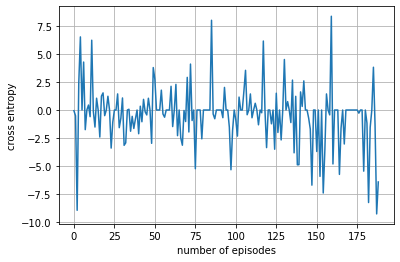

In [24]:
from matplotlib import pyplot as plt
array = (np.array(cross_entropy))
x = (array[:,0])
y = (array[:,1])

plt.plot(x,y)
plt.xlabel("number of episodes")
plt.ylabel("cross entropy")
plt.grid()
plt.show()
